In [1]:
import os

import pandas as pd
import torch
import torchmetrics
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

/home/yata/Desktop/pytorch-tutorials/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.makedirs("../dataset", exist_ok=True)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

In [4]:
train_set = datasets.CIFAR10(
    "../dataset", train=True, download=True, transform=transform
)
test_set = datasets.CIFAR10(
    "../dataset", train=False, download=False, transform=transform
)

Files already downloaded and verified


In [5]:
train_set

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../dataset
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [6]:
train_set.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
# Reduce data dut to avoide OOM
train_set = torch.utils.data.Subset(train_set, list(range(0, 500)))
valid_set = torch.utils.data.Subset(train_set, list(range(0, 50)))
test_set = torch.utils.data.Subset(train_set, list(range(50, 100)))

In [8]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=16)
valid_loader = DataLoader(train_set, shuffle=True, batch_size=10)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1)

### Define model

In [9]:
model = models.resnet18(weights="DEFAULT")

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Fine tuning setting


In [11]:
# for param in model.parameters():
#     param.requires_grad = False

In [12]:
# Change output unit number
num_features = model.fc.in_features
print(num_features)

model.fc = torch.nn.Linear(num_features, 10)

512


In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [17]:
num_epoch = 10

for epoch in range(num_epoch):
    running_loss = 0.0
    model.train()
    for batch in train_loader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()  # Initialize params
        outputs = model(inputs)  # Forward
        loss = criterion(outputs, labels)  # Calc loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update params
        running_loss += loss.item()  # Calc total
        train_acc.update(outputs, labels)  # Calc Acc

    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_acc.update(outputs, labels)

    print(
        f"epoch:{epoch+1}, loss:{running_loss / len(train_loader):.2f}, train_acc:{train_acc.compute():.2f}, val_acc:{val_acc.compute():.2f}"
    )

epoch:1, loss:1.81, train_acc:0.38, val_acc:0.35
epoch:2, loss:1.39, train_acc:0.46, val_acc:0.45
epoch:3, loss:0.95, train_acc:0.53, val_acc:0.50
epoch:4, loss:0.68, train_acc:0.60, val_acc:0.60
epoch:5, loss:0.48, train_acc:0.64, val_acc:0.64
epoch:6, loss:0.58, train_acc:0.67, val_acc:0.68
epoch:7, loss:0.55, train_acc:0.69, val_acc:0.71
epoch:8, loss:0.45, train_acc:0.71, val_acc:0.73
epoch:9, loss:0.29, train_acc:0.73, val_acc:0.75
epoch:10, loss:0.19, train_acc:0.75, val_acc:0.77


### Save and load model


In [18]:
torch.save(model.state_dict(), "model_weight.pth")

In [19]:
model = models.resnet18(weights="DEFAULT")
num_features = model.fc.in_features
print(num_features)
model.fc = torch.nn.Linear(num_features, 10)
model.to(device)

512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### GrandCAM


In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC

import matplotlib.pyplot as plt


In [21]:
# for resnet18
target_layers = [model.layer4[-1]]

In [22]:
target_layers

[BasicBlock(
   (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 )]

In [23]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

In [24]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

vis_set = datasets.CIFAR10(
    "../dataset", train=True, download=False, transform=transform
)

In [25]:
vis_set.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [26]:
for i, data in enumerate(vis_set):
    if data[1] == 3:
        print("cat: ", i)
    elif data[1] == 5:
        print("doc: ", i)
    elif data[1] == 7:
        print("horse: ", i)
    
    if i == 100:
        break

horse:  7
cat:  9
horse:  11
horse:  12
cat:  17
cat:  21
cat:  26
doc:  27
cat:  33
cat:  36
horse:  37
cat:  38
cat:  39
doc:  40
horse:  43
doc:  51
horse:  52
doc:  56
cat:  59
horse:  68
doc:  70
horse:  73
cat:  74
cat:  78
cat:  80
doc:  81
doc:  83
horse:  84
horse:  85
horse:  87
cat:  91


In [36]:
def vis_gradcam(data):
    inputs, label = data
    grayscale_cam = cam(input_tensor=inputs.unsqueeze(0), targets=[ClassifierOutputTarget(label)])
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(inputs.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(inputs.permute(1, 2, 0).numpy())
    ax[1].imshow(visualization)

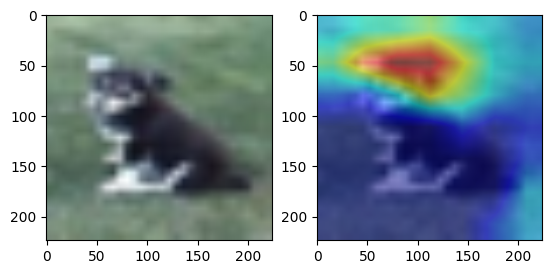

In [37]:
vis_gradcam(vis_set[70])

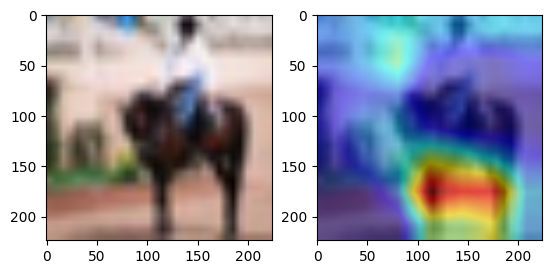

In [38]:
vis_gradcam(vis_set[11])